In [118]:
import numpy as np
import matplotlib.pyplot as plt

In [119]:
HX_length = 100
distance_to_blocks = 24.5
throttle_length = 32.64
block_length = 84
block_space = 21
vertical_block_length = 14.3




receiver_length = HX_length  # Length of the receiver
receiver_position = (0.0,receiver_length/2)

panel_length = throttle_length  # Length of the throttle panelottle_length  # Length of the throttle panelottle_length  # Length of the throttle panelottle_length  # Length of the throttle panel
panel_position = (distance_to_blocks,(receiver_length/2 - block_space/2)+(panel_length/2))  # X-position of the blocking panel (center of the panel)
panel_angle = 75 #Between 0.1 and 89.9 where 90 is fully open
panel_angle_range = np.arange(-90, 95, 5)
#panel_angle_range = [89.9, 45, 0.01]
print(panel_position[1] - (panel_length/2))
print(panel_position[1] + (panel_length/2))



#diffuser_position = 10.0  # Position of the diffuse surface (emitter)
diffuse_surface_length = block_length  # Length of the diffuse surface (emitter)
diffuser_position = (panel_position[0]+ diffuse_surface_length/2,receiver_length/2 - block_space/2)  # Position of the receiver

diffuser_start_x = diffuser_position[0] - diffuse_surface_length/2
diffuser_start_y = diffuser_position[1]
diffuser_end_x = diffuser_position[0] + diffuse_surface_length/2
diffuser_end_y = diffuser_position[1]
print( diffuser_start_y)


barrier_length = diffuse_surface_length
barrier_position = (diffuser_position[0], diffuser_position[1] + block_space)


vertical_diffuser_surface_length = vertical_block_length
vertical_diffuser_position = (distance_to_blocks, barrier_position[1] + vertical_diffuser_surface_length/2)
print(vertical_diffuser_position)

# Simulation parameters


39.5
72.14
39.5
(24.5, 67.65)


In [120]:
def generate_old__particle():
    position = np.random.uniform(0, diffuse_surface_length)  # Random position on the emitte
    rand_cos = np.random.uniform(0, 1) # Distribution has to follow lambers law for diffuse surfaces
    angle = np.arccos(rand_cos)-np.pi/2
    return position, angle

def generate_particle_path(midpoint, length):
    x_position = np.random.uniform(midpoint[0]-length/2, midpoint[0]+length/2)  # Random position on the emitte
    rand_cos = np.random.uniform(-1, 1) # Distribution has to follow lambers law for diffuse surfaces
    angle = np.arccos(rand_cos)
    #print(angle)
    slope = np.tan(angle)  # Slope of the trajectory (dy/dx)
    y_inter = midpoint[1] - slope *x_position
    return slope, y_inter

def generate_vertical_particle_path(midpoint, length):
    y_position = np.random.uniform(midpoint[1]-length/2, midpoint[1]+length/2)  # Random position on the emitte
    rand_cos = np.random.uniform(-1, 1) # Distribution has to follow lambers law for diffuse surfaces
    angle = np.arccos(rand_cos)
    angle = angle + np.pi/2 # Angle towards to the left

    slope = np.tan(angle)  # Slope of the trajectory (dy/dx)
    #print(slope)
    y_inter = y_position - slope *midpoint[0]
    print(y_inter)
    return slope, y_inter

# Check if the particle hits a vertical panel
def hits_vertical_panel(particle_slope, particle_intercept):
    global counter
    y_at_panel = particle_slope * (panel_position[0]) + particle_intercept  # y-position when x = panel_position
    if (panel_position[1] + panel_length/2) > (y_at_panel) > (panel_position[1] - panel_length/2) :
         # Particle hits the panel
        return True
    return False
def hits_horizontal_panel(particle_slope, particle_intercept):
    global counter
    x_at_barrier = (barrier_position[1] - particle_intercept ) /particle_slope
    if (diffuser_start_x) <= (x_at_barrier) <= (diffuser_end_x) :
        counter += 1
        return True
    return False

def hits_slanted_panel(particle_slope, particle_intercept, panel_angle):
    global counter
    panel_angle = np.radians(90-panel_angle)
    panel_start_x = panel_position[0] - (panel_length/2) * np.cos(panel_angle)
    panel_start_y = panel_position[1] - (panel_length/2) * np.sin(panel_angle)
    panel_end_x = panel_position[0] + (panel_length/2) * np.cos(panel_angle)
    panel_end_y = panel_position[1] + (panel_length/2) * np.sin(panel_angle)

    
    panel_slope = np.tan(panel_angle)
    panel_intercept = panel_start_y - panel_slope * panel_start_x
     
    # Solve for x_intersection:
    if particle_slope != panel_slope:  # Ensure the slopes aren't equal (no intersection)
        
        x_intersection = (panel_intercept - particle_intercept) / (particle_slope - panel_slope)
        y_intersection = particle_slope * (x_intersection) + particle_intercept
        y_intersection2 = panel_slope * (x_intersection) + panel_intercept
        if np.abs(y_intersection - y_intersection2) < 0.0001:
            pass
        # Check if the intersection point is within the bounds of the slanted panel
        if panel_start_x <= x_intersection <= panel_end_x or panel_start_y <= y_intersection <= panel_end_y:
            
            return True  # The particle hits the panel
        
    return False  # No hit

def hits_receiver(particle_slope, particle_intercept):

    y_at_receiver = particle_slope * (receiver_position[0]) + particle_intercept  # y-position at receiver x = 1.0
    if 0 <= y_at_receiver <= receiver_length:
        return particle_slope, y_at_receiver  # The particle hits the receiver
    return False

def view_factor_parallel_plates(w_i, w_j, L):
    # Calculate the normalized widths
    W_i = w_i / L
    W_j = w_j / L
    F_ij = (np.sqrt((W_i + W_j)**2 + 4) - np.sqrt((W_i - W_j)**2 + 4)) / (2 * W_i)
    return F_ij
def view_factor_perpendicular_plates(emmitor, panel):
    F_ij = (1 + (panel/emmitor) - ( 1 + (panel/emmitor)**2 )**0.5)/2
    return F_ij


In [121]:
num_particles = 50
counter = 0
list= []

slanted_panel_vf_range = []
slanted_reciever_vf_range = []
vertical_panel_vf_range = []
vertical_reciever_vf_range = []

for panel_angle in panel_angle_range:
    # Simulation loop
    vertical_reciever_hits = 0
    vertical_panel_hits = 0
    slanted_reciever_hits = 0
    slanted_panel_hits = 0


    for _ in range(num_particles):
        particle_slope1, particle_intercept1 = generate_particle_path(diffuser_position, diffuse_surface_length)  # Generate random particle emission
        particle_slope2, particle_intercept2 = generate_vertical_particle_path(vertical_diffuser_position, vertical_diffuser_surface_length)  # Generate random particle emission
        
        if not hits_horizontal_panel(particle_slope1, particle_intercept1):
            if particle_slope1 < 0: #Don't include ones that are pointing away
                # # Check if it hits horizontal the panel
                # if hits_vertical_panel(particle_slope1, particle_intercept1):  # Check if it hits vertical the panel
                #     vertical_panel_hits += 1
                # else:
                #     if hits_receiver(particle_slope1, particle_intercept1):  # Check if it hits the receiver
                #         vertical_reciever_hits += 1
                
                if hits_slanted_panel(particle_slope1, particle_intercept1, panel_angle):  # Check if it hits the slanted panel
                    slanted_panel_hits += 1
                else:
                    hit = hits_receiver(particle_slope1, particle_intercept1)
                    if hit is not False:  # Check if it hits the receiver
                        list.append(hit)  # Store the particle path for later analysis
                        
                        slanted_reciever_hits += 1
        if hits_slanted_panel(particle_slope2, particle_intercept2, panel_angle):
            vertical_panel_hits += 1
        else:
            hit2 = hits_receiver(particle_slope2, particle_intercept2)
            if hit2 is not False:  # Check if it hits the receiver
                vertical_panel_hits += 1

    # Estimate view factor
    vertical_panel_vf = vertical_panel_hits / num_particles
    vertical_reciever_vf = vertical_reciever_hits / num_particles
    vertical_panel_vf_range.append(vertical_panel_vf)
    vertical_reciever_vf_range.append(vertical_reciever_vf)

    slanted_panel_vf = slanted_panel_hits / num_particles
    slanted_reciever_vf = slanted_reciever_hits / num_particles
    slanted_panel_vf_range.append(slanted_panel_vf)
    slanted_reciever_vf_range.append(slanted_reciever_vf)

analytical_vertical_panel_vf = view_factor_perpendicular_plates(diffuse_surface_length, panel_length)
analytical_vertical_reciever_vf = analytical_vertical_panel_vf * view_factor_parallel_plates(diffuse_surface_length, receiver_length, np.abs(receiver_position[0]-panel_position[0]))

print(counter)
print("--------------------------------------------------------")
print("Estimated blocks-vertical throttle VF:", slanted_panel_vf)
print("Estimated blocks-HX Box VF:", slanted_reciever_vf)
print("--------------------------------------------------------\n")
print("Max blocks-throttle VF:", analytical_vertical_panel_vf)
print("Max blocks-HX Box VF:", analytical_vertical_reciever_vf)

59.17400926227441
69.0797751882112
56.66331497900842
83.66731395170714
69.74931487642208
56.31138037763101
84.88939173171214
56.60835992157487
33.54285608484098
80.05513581822419
101.47561953871264
73.99267167597527
16.514011286344825
26.341447919429733
64.15514433176831
52.239283762171965
81.69949416367186
91.59389681761323
131.31725047465844
78.52200557251291
98.06358758190606
26.019326951716636
46.778015047454446
80.08606858121684
58.97150147590917
74.23093743368648
91.23503521878008
63.0732316535657
79.5047909521079
82.1884547124997
87.4681524702577
90.27913419815366
29.687528950721557
36.52651788806503
78.34405063799687
68.81874670067134
-38.4197659484517
71.75108357335189
76.43867189301278
68.32218508532021
64.20042828079383
89.0749348390695
106.55226237506646
54.51457021683564
68.66725553384681
47.50251612903736
51.67220995990971
67.63210050490407
86.70461505078177
103.55986015766798
43.63773857064232
74.12330864155757
16.285981849559015
72.88505493832058
48.52871475370178
76.24

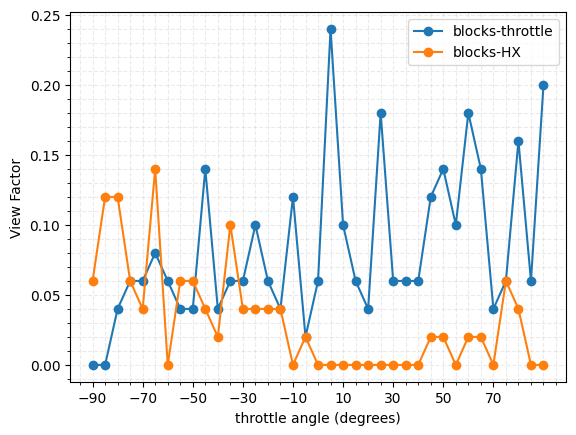

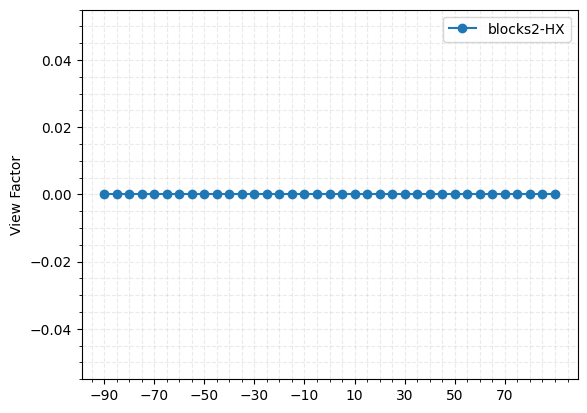

[-90 -85 -80 -75 -70 -65 -60 -55 -50 -45 -40 -35 -30 -25 -20 -15 -10  -5
   0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90]
[0.06, 0.12, 0.12, 0.06, 0.04, 0.14, 0.0, 0.06, 0.06, 0.04, 0.02, 0.1, 0.04, 0.04, 0.04, 0.04, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.02, 0.0, 0.02, 0.02, 0.0, 0.06, 0.04, 0.0, 0.0]
[  0.          14.28571429  14.28571429  14.28571429  42.85714286
  42.85714286  57.14285714  28.57142857  42.85714286  71.42857143
  57.14285714  71.42857143 100.          71.42857143  28.57142857
   0.           0.          28.57142857]


In [122]:

# Plot how the view factors change for the depending on fi the throttles are opening inside or outside
plt.plot(panel_angle_range, slanted_panel_vf_range, label='blocks-throttle', marker='o' )
plt.plot(panel_angle_range, slanted_reciever_vf_range, label='blocks-HX', marker='o')
plt.xlabel('throttle angle (degrees)')

plt.ylabel('View Factor')
plt.xticks(np.arange(-90, 90, 20))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', alpha=0.25)
plt.legend()
plt.show()

#plt.plot(panel_angle_range, vertical_panel_vf_range, label='blocks2-throttle', marker='o' )

plt.plot(panel_angle_range, vertical_reciever_vf_range, label='blocks2-HX', marker='o')
plt.ylabel('View Factor')
plt.xticks(np.arange(-90, 90, 20))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', alpha=0.25)
plt.legend()
plt.show()




print(panel_angle_range)

print(slanted_reciever_vf_range)
print(summed_slanted_reciever_vf_range)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


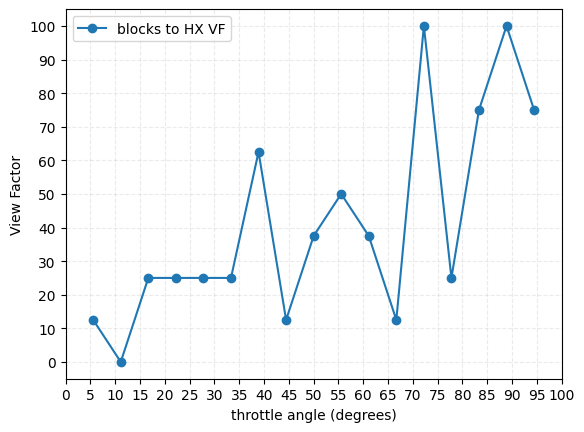

In [123]:
#If even number of array
#summed_angle_range = np.flip(panel_angle_range[:(len(panel_angle_range)//2)] + np.flip(panel_angle_range[-len(panel_angle_range)//2 :]))
summed_angle_range = np.flip(panel_angle_range[:len(panel_angle_range)//2]) + (panel_angle_range[len(panel_angle_range)//2+1:])
print(summed_angle_range)
summed_slanted_panel_vf_range = np.flip(slanted_panel_vf_range[:len(slanted_panel_vf_range)//2]) + (slanted_panel_vf_range[len(slanted_panel_vf_range)//2+1:])
summed_slanted_reciever_vf_range = np.flip(slanted_reciever_vf_range[:len(slanted_reciever_vf_range)//2]) + (slanted_reciever_vf_range[len(slanted_reciever_vf_range)//2+1:])

# Normalize to 100%
summed_slanted_reciever_vf_range = (summed_slanted_reciever_vf_range / np.max(summed_slanted_reciever_vf_range)) * 100
half_angle_range = panel_angle_range[len(panel_angle_range)//2 + 1:]
half_angle_range = half_angle_range/90 * 100

#plt.plot(half_angle_range, summed_slanted_panel_vf_range, label='blocks-throttle', marker='o' )
plt.plot(half_angle_range[:-1], summed_slanted_reciever_vf_range[:-1], label='blocks to HX VF', marker='o')
plt.xlabel('throttle angle (degrees)')

plt.ylabel('View Factor')
plt.xticks(np.arange(0, 105, 5))
plt.yticks(np.arange(0,110,10))
#plt.minorticks_on()
plt.grid(which='both', linestyle='--', alpha=0.25)
plt.legend()
plt.show()


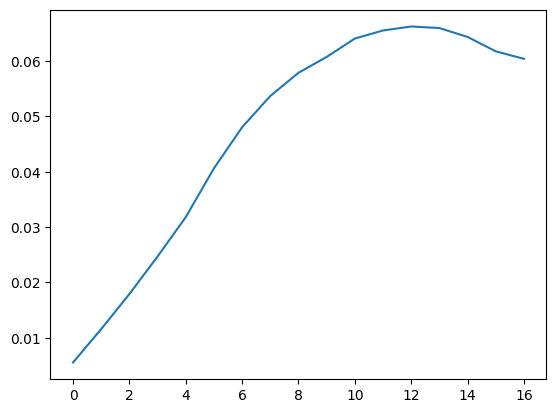

In [124]:
try1 = [0.087098, 0.038148, 0.044924, 0.05177, 0.056592, 0.059796, 0.060786, 0.061106, 0.058964, 0.056922, 0.0533, 0.047908, 0.040606, 0.031796, 0.024684, 0.017894, 0.011566, 0.005522, 0.0, 8e-06, 8.2e-05, 0.000176, 0.000478, 0.000878, 0.001694, 0.002474, 0.003478, 0.005064, 0.006638, 0.008646, 0.010878, 0.013968, 0.016916, 0.020076, 0.024014, 0.027576, 0.0]
try1 = try1[::-1]

try2 = [0.055796, 0.036784, 0.042878, 0.047818, 0.050978, 0.052452, 0.05373, 0.053238, 0.051356, 0.0493, 0.04595, 0.040982, 0.035212, 0.028112, 0.020592, 0.01418, 0.008836, 0.004044, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8e-06, 0.000136, 0.000394, 0.000966, 0.001794, 0.002972, 0.004752, 0.006466, 0.009384, 0.0126, 0.016842, 0.022268, 0.00126]
try3 = np.array(try1) + np.array(try2)
plt.plot(try3[19:-1])
